# Problems

This notebook explores the fundamental differences between **classical and quantum algorithms**, with a particular focus on the **Deutsch** and **Deutsch–Jozsa algorithms**. These algorithms are foundational examples demonstrating how quantum computing can achieve computational advantages over classical approaches by leveraging quantum phenomena such as **superposition** and **interference**.

**Author:** Cian Dicker-Hughes  
**Module:** Emerging Technologies, Summer 25/26

In [248]:
# Imports
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from IPython.display import display

## Overview

The [Deutsch–Jozsa algorithm](https://quantum.cloud.ibm.com/learning/en/modules/computer-science/deutsch-jozsa) is one of the earliest examples highlighting the potential power of quantum computing. While the problem it solves may seem simple, it elegantly illustrates how a quantum computer can determine a global property of a function with **exponentially fewer queries** than any classical deterministic algorithm.

In this notebook, we will:
1. Generate random constant and balanced Boolean functions classically
2. Analyze the classical computational cost of distinguishing function types
3. Build quantum oracles using [Qiskit](https://www.ibm.com/quantum/qiskit)
4. Implement Deutsch's algorithm for single-bit functions
5. Scale to the full Deutsch–Jozsa algorithm for multi-bit functions

## Table of Contents

| Problem | Title | Description |
|---------|-------|-------------|
| [Problem 1](#problem1) | Generating Random Boolean Functions | Create constant and balanced functions for testing |
| [Problem 2](#problem2) | Classical Testing for Function Type | Determine function type using classical computation |
| [Problem 3](#problem3) | Quantum Oracles | Build quantum oracles for single-bit Boolean functions |
| [Problem 4](#problem4) | Deutsch's Algorithm with Qiskit | Implement and demonstrate Deutsch's algorithm |
| [Problem 5](#problem5) | Scaling to Deutsch–Jozsa | Extend to four-bit functions using Deutsch–Jozsa |

## Problem 1: Generating Random Boolean Functions
<a id="problem1"></a>
___

### Background

The [Deutsch–Jozsa algorithm](https://quantum.cloud.ibm.com/learning/en/modules/computer-science/deutsch-jozsa) operates on Boolean functions $f: \{0,1\}^n \rightarrow \{0,1\}$ that are guaranteed to be either:

- **Constant**: The function returns the same value (0 or 1) for all possible inputs
- **Balanced**: The function returns 0 for exactly half of the inputs and 1 for the other half

For a function with $n$ input bits, there are $2^n$ possible input combinations. A constant function has only 2 possibilities (always 0 or always 1), while balanced functions are much more numerous—for 4-bit inputs, there are $\binom{16}{8} = 12,870$ balanced functions.

### Problem Statement

> Write a Python function `random_constant_balanced` that returns a randomly chosen function from the set of constant or balanced functions taking four Boolean arguments as inputs.

**References:**
- [Deutsch–Jozsa Algorithm - IBM Quantum Learning](https://quantum.cloud.ibm.com/learning/en/modules/computer-science/deutsch-jozsa)
- [Python Boolean Values - Real Python](https://realpython.com/python-boolean/)

### `random_constant()` Function

This function generates a **constant function** that always returns the same value (0 or 1) regardless of the input.

- **Input:** None (generates randomly)
- **Output:** A function that takes 4 boolean arguments (a, b, c, d) and always returns 0 or 1
- **Key Property:** All 16 possible inputs return the same value

In [249]:
# Constant Function Generator
def random_constant():
    """
    Returns a constant function that always returns the same value (0 or 1)
    regardless of the 4 boolean inputs (a, b, c, d)
    """
    # Randomly pick 0 or 1
    constant_value = np.random.choice([0, 1])
    return lambda a, b, c, d: constant_value

### `random_balanced()` Function

This function generates a **balanced function** that returns 1 for exactly half of the 16 possible inputs and 0 for the other half.

- **Input:** None (generates randomly)
- **Output:** A function that takes 4 boolean arguments (a, b, c, d)
- **Key Property:** Returns 1 for exactly 8 out of 16 inputs, and 0 for the other 8
- **Method:** Creates a random mapping by shuffling 8 ones and 8 zeros across all possible input combinations

In [250]:
# Balanced Function Generator
def random_balanced():
    """
    Returns a balanced function that returns 1 for exactly 8 out of 16 inputs
    and 0 for the other 8 inputs
    """
    # Create array of 8 ones and 8 zeros, then shuffle randomly
    outputs = np.random.permutation([1] * 8 + [0] * 8)
    
    # Create a mapping from each input combination to an output
    # For each number from 0 to 15, extract its 4 bits as (a, b, c, d)
    input_map = {}
    for i in range(16):
        # Extract each bit: bit 3, 2, 1, 0
        a = (i >> 3) & 1
        b = (i >> 2) & 1
        c = (i >> 1) & 1
        d = i & 1
        input_map[(a, b, c, d)] = outputs[i]

    return lambda a, b, c, d: input_map[(a, b, c, d)]

### `random_constant_balanced()` Function

This is the **main function** that randomly chooses between creating a constant or balanced function.

- **Input:** None (generates randomly)
- **Output:** A function that is either constant or balanced (randomly chosen)
- **Purpose:** Provides test functions for the Deutsch-Jozsa algorithm to classify
- **Usage:** Call this function to get a random test case, then use the Deutsch-Jozsa algorithm to determine if it's constant or balanced

In [251]:
# Combined Function (randomly picks constant or balanced)
def random_constant_balanced():
    """
    Returns a randomly chosen function that is either:
    - Constant: always returns 0 or always returns 1
    - Balanced: returns 1 for exactly half (8 out of 16) input combinations
    """
    is_constant = np.random.choice([True, False])
    
    if is_constant:
        return random_constant()
    else:
        return random_balanced()

In [252]:
# Testing the function
f = random_constant_balanced()

# Test with some inputs
print("Testing the randomly generated function with different inputs:")
test_inputs = [
    (0, 0, 0, 0), 
    (0, 0, 0, 1),  
    (0, 0, 1, 0), 
    (0, 0, 1, 1), 
    (0, 1, 0, 0), 
    (0, 1, 0, 1),
    (0, 1, 1, 0), 
    (0, 1, 1, 1), 
    (1, 0, 0, 0),  
    (1, 0, 0, 1),
    (1, 0, 1, 0),
    (1, 0, 1, 1),
    (1, 1, 0, 0),
    (1, 1, 0, 1),
    (1, 1, 1, 0),
    (1, 1, 1, 1),
]

for inputs in test_inputs:
    result = f(*inputs)
    print(f"f{inputs} = {result}")

Testing the randomly generated function with different inputs:
f(0, 0, 0, 0) = 0
f(0, 0, 0, 1) = 0
f(0, 0, 1, 0) = 0
f(0, 0, 1, 1) = 0
f(0, 1, 0, 0) = 0
f(0, 1, 0, 1) = 0
f(0, 1, 1, 0) = 0
f(0, 1, 1, 1) = 0
f(1, 0, 0, 0) = 0
f(1, 0, 0, 1) = 0
f(1, 0, 1, 0) = 0
f(1, 0, 1, 1) = 0
f(1, 1, 0, 0) = 0
f(1, 1, 0, 1) = 0
f(1, 1, 1, 0) = 0
f(1, 1, 1, 1) = 0


## Problem 2: Classical Testing for Function Type
<a id="problem2"></a>
___

### Background

To appreciate the [quantum advantage](https://www.quantamagazine.org/john-preskill-explains-quantum-supremacy-20191002/) offered by Deutsch's algorithm, we must first understand the **classical cost** of solving this problem. Classically, determining whether a function is constant or balanced requires evaluating the function multiple times.

The key insight: in the **worst case**, a classical algorithm must query the function $2^{n-1} + 1$ times to be 100% certain. For a 4-bit input function, this means up to **9 queries**. However, a quantum computer can solve this problem with just **1 query** using the Deutsch–Jozsa algorithm.

### Problem Statement

> Write a Python function `determine_constant_balanced` that takes as input a function `f`, as defined in Problem 1. The function should analyze `f` and return the string `"constant"` or `"balanced"` depending on whether the function is constant or balanced. Write a brief note on the efficiency of your solution. What is the maximum number of times you need to call `f` to be 100% certain whether it is constant or balanced?

**References:**
- [Deutsch's Algorithm - IBM Quantum Learning](https://quantum.cloud.ibm.com/learning/en/courses/fundamentals-of-quantum-algorithms/quantum-query-algorithms/deutsch-algorithm)
- [Quantum Supremacy Explained - Quanta Magazine](https://www.quantamagazine.org/john-preskill-explains-quantum-supremacy-20191002/)

### `determine_constant_balanced(f)` Function

- **Input:** A function `f` that takes 4 boolean arguments and returns 0 or 1
- **Output:** A string: `"constant"` or `"balanced"`
- **Key Property:** Requires evaluating all 16 possible input combinations to be 100% certain of the result
- **Method:** Tests `f` on all 16 possible inputs (0,0,0,0) through (1,1,1,1), counts the number of 1s returned, and classifies as constant if count is 0 or 16, balanced if count is exactly 8

In [253]:
def determine_constant_balanced(f):
    """
    Determines if the given function f is constant or balanced by evaluating it on all 16 possible input combinations.
    
    Args:
        f: A function that takes 4 boolean arguments and returns 0 or 1
    
    Returns:
        string: "constant" or "balanced"

    Note:
        Requires 16 function calls to be 100% certain of the result.
        This is the classical cost of solving this classification problem.
    """
    # Collect outputs for all 16 possible inputs
    outputs = []
    for i in range(16):
        a = (i >> 3) & 1
        b = (i >> 2) & 1
        c = (i >> 1) & 1
        d = i & 1
        outputs.append(f(a, b, c, d))
    # print(outputs)
    
    # Count the number of 1s
    count_ones = sum(outputs)
    
    # Constant: all outputs are the same (0 ones or 16 ones)
    # Balanced: exactly half are 1s (8 ones)
    if count_ones == 0 or count_ones == 16:
        return "constant"
    else:
        return "balanced"

In [254]:
# Test with your random_constant_balanced function
f = random_constant_balanced()
print(determine_constant_balanced(f))

balanced


## Problem 3: Quantum Oracles
<a id="problem3"></a>
___

### Background

A [quantum oracle](https://quantumcomputing.stackexchange.com/a/4626) is a black-box quantum operation that encodes a classical function into a quantum circuit. In Deutsch's algorithm, oracles implement the transformation:

$$U_f |x\rangle |y\rangle = |x\rangle |y \oplus f(x)\rangle$$

Where $\oplus$ denotes XOR (addition modulo 2). This means the oracle flips the target qubit if and only if $f(x) = 1$.

### The Four Single-Bit Boolean Functions

For a single Boolean input, there are exactly four possible functions:

| Function | $f(0)$ | $f(1)$ | Type | Description |
|----------|--------|--------|------|-------------|
| $f_1$ | 0 | 0 | Constant | Always returns 0 |
| $f_2$ | 0 | 1 | Balanced | Identity function |
| $f_3$ | 1 | 0 | Balanced | NOT function |
| $f_4$ | 1 | 1 | Constant | Always returns 1 |

### Problem Statement

> Using Qiskit, create the appropriate quantum oracles for each of the possible single-Boolean-input functions used in Deutsch's algorithm. Demonstrate their use and explain how each oracle implements its corresponding function.

**References:**
- [Deutsch's Algorithm - IBM Quantum Learning](https://quantum.cloud.ibm.com/learning/en/courses/fundamentals-of-quantum-algorithms/quantum-query-algorithms/deutsch-algorithm)
- [Superposition - Caltech Science Exchange](https://scienceexchange.caltech.edu/topics/quantum-science-explained/quantum-superposition)
- [What is a Quantum Oracle? - Stack Exchange](https://quantumcomputing.stackexchange.com/a/4626)

In [255]:
# Oracles for Deutsch's Problem

# f1: Constant 0 — always returns 0, no gates required
def oracle_f1():
    """Constant 0: f(x) = 0 for all x. No gates needed."""
    qc = QuantumCircuit(2)
    return qc

# f2: Balanced identity — returns 0 for input 0, returns 1 for input 1
def oracle_f2():
    """Balanced identity: f(x) = x. CNOT flips target when x=1."""
    qc = QuantumCircuit(2)
    qc.cx(0, 1)  # CNOT: control=qubit 0, target=qubit 1
    return qc

# f3: Balanced NOT — returns 1 for input 0, returns 0 for input 1
def oracle_f3():
    """Balanced NOT: f(x) = NOT x. Flip target, then apply CNOT."""
    qc = QuantumCircuit(2)
    qc.x(1)      # flip target
    qc.cx(0, 1)  # CNOT
    return qc

# f4: Constant 1 — always returns 1, target qubit always flipped
def oracle_f4():
    """Constant 1: f(x) = 1 for all x. X gate flips target unconditionally."""
    qc = QuantumCircuit(2)
    qc.x(1)      # always flip target
    return qc

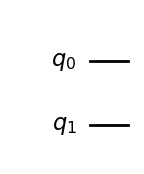

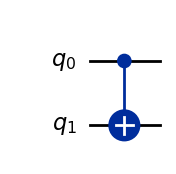

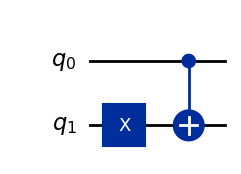

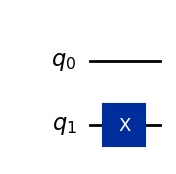

In [256]:
display(oracle_f1().draw('mpl'))
display(oracle_f2().draw('mpl'))
display(oracle_f3().draw('mpl'))
display(oracle_f4().draw('mpl'))

In [257]:
# Test oracle_f2 with input |0>|0>
qc = oracle_f2()
sv = Statevector.from_label('00')
result = sv.evolve(qc)
print(result)

Statevector([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2))


## Problem 4: Deutsch's Algorithm with Qiskit
<a id="problem4"></a>
___

In [258]:
# Problem 4

## Problem 5: Scaling to the Deutsch–Jozsa Algorithm
<a id="problem"></a>
___

In [259]:
# Problem 5

## not imprortance stuff for now

In [260]:
# Deterministic operations
def f1(a):
    return 0

def f2(a):
    if a == 0:
        return 0
    return 1

def f3(a):
    if a == 0:
        return 1
    return 0

def f4(a):
    return 1

In [261]:
# example usage of the random_constant_balanced function
f = random_constant_balanced()
print(f)
result = f(0, 0, 0, 1)
print(result)

<function random_balanced.<locals>.<lambda> at 0x70e1a8219080>
1
